In [1]:
import numpy as np
import pandas as pd
import os
from gensim.models import Word2Vec
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

N=16153

%pwd

/home/cseadmin/data/cys/anaconda3/envs/dz/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


'/home/cseadmin/data/cys/TrafficFlowModel/data_process'

限制轨迹长度 @deprecated

---

In [2]:
walks=[]
walk_len=2
choices=100

n=0

for file in os.listdir("../data/taxi_after_proc/tracks"):
    df_track=pd.read_csv(f"../data/taxi_after_proc/tracks/{file}")
    arr_track=list(df_track["track"].dropna().astype("int32").astype("str").values)
    if len(arr_track)-1-walk_len<0:
            continue
    for _ in range(choices):
        start_index=random.randint(0, len(arr_track)-1-walk_len)
        walks.append(arr_track[start_index:start_index+walk_len])

In [3]:
len(walks)

11000

In [4]:
w2v_model=Word2Vec(walks, sg=1, hs=1, vector_size=128, window=2, min_count=1, workers=4)

w2v_model.save("./w2v_model_2.model")

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

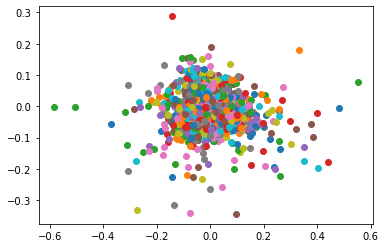

In [5]:

x = []
y = []
# node_vec={}

plt.figure(figsize=(10, 10))
fig, ax = plt.subplots()
for node in range(16153):
    try:
      vector = w2v_model.wv[str(node)]
    except KeyError:
      continue
    # print("%s:"%(str(node)), end="")
    # print(vector)
    x.append(vector[0])
    y.append(vector[1])
    # node_vec[str(node)] = vector
    # trash=ax.annotate(str(node), (vector[0], vector[1]))
   
for i in range(len(x)):
    trash=ax.scatter(x[i], y[i])

所有轨迹

---

In [55]:
walks_track=[]

for file in os.listdir("../data/taxi_after_proc/tracks"):
    df_track=pd.read_csv(f"../data/taxi_after_proc/tracks/{file}")
    arr_track=list(df_track["track"].dropna().astype("int32").astype("str").values)
    walks_track.append(arr_track)

In [56]:
w2v_model_track=Word2Vec(walks_track, sg=1, hs=1, vector_size=128, window=10, min_count=1, workers=4)

w2v_model_track.save("./w2v_model_track.model")

In [57]:
tsne_track=TSNE(n_components=2, init="pca", n_jobs=2)
vec2d_track=tsne_track.fit_transform(w2v_model_track.wv.get_normed_vectors()).T

KeyboardInterrupt: 

<Figure size 1800x1080 with 0 Axes>

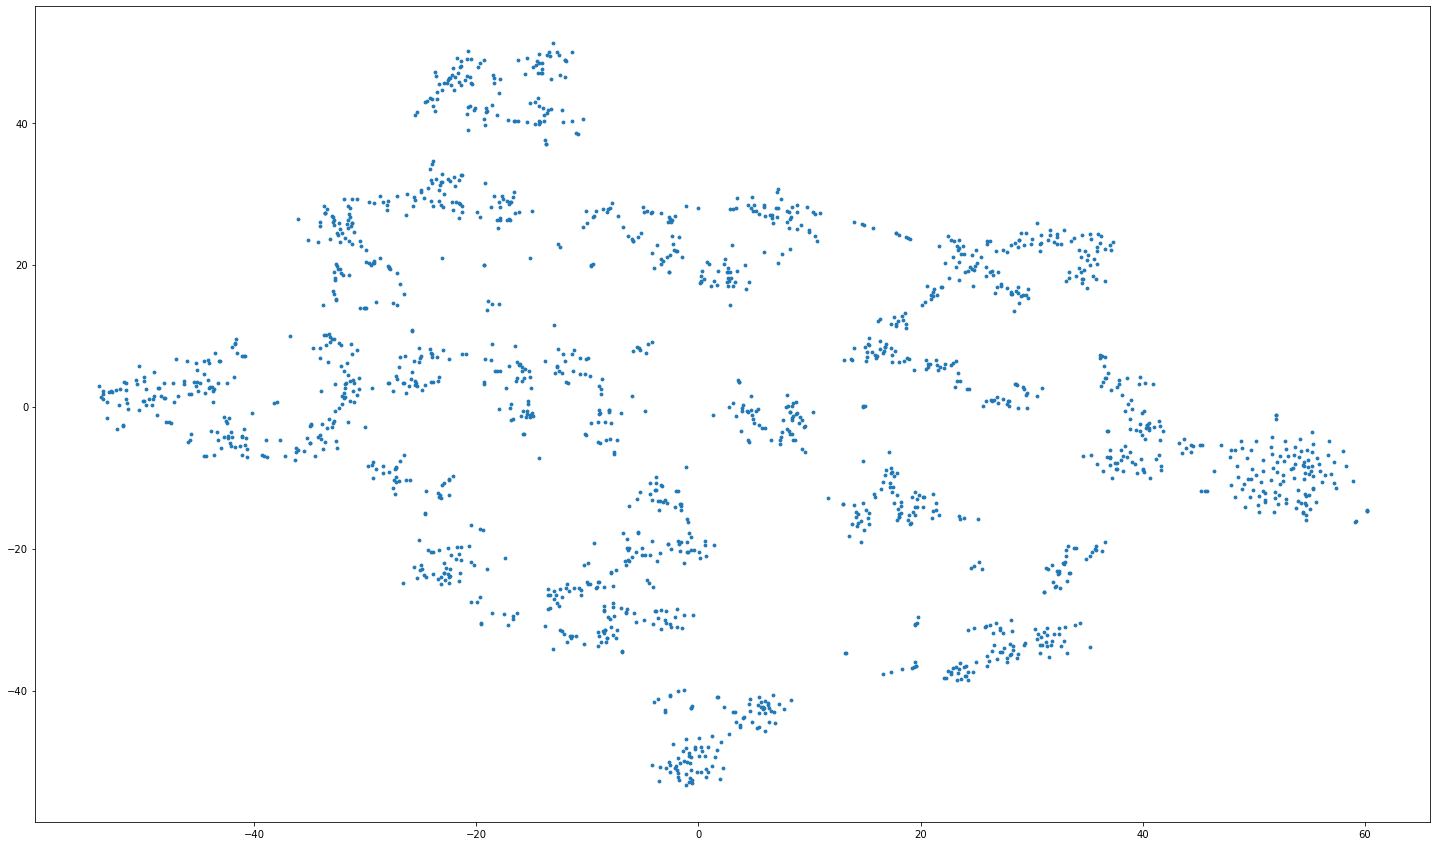

In [19]:
plt.figure(figsize=(25, 15))
plt.scatter(vec2d_track[0], vec2d_track[1], s=8)
plt.show()

In [67]:
w2v_model_track_window2=Word2Vec(walks_track, sg=1, hs=1, vector_size=128, window=2, min_count=1, workers=4)

w2v_model_track_window2.save("./w2v_model_track_window2.model")

重新计算转移矩阵

---

In [17]:
from tqdm import tqdm

trans_matrix_recalc=np.zeros((9, N, N), dtype=np.int32)

for file in tqdm(os.listdir("../data/taxi_after_proc/tracks")):
    df_track=pd.read_csv(f"../data/taxi_after_proc/tracks/{file}")
    track_list=df_track["track"].dropna().astype("int32").values
    time_list=df_track["time_seconds"].values
    for i in range(len(track_list)-1):
        trans_matrix_recalc[0][track_list[i]][track_list[i+1]]+=1
        trans_matrix_recalc[int(time_list[i]/10800)+1][track_list[i]][track_list[i+1]]+=1
        
np.count_nonzero(trans_matrix_recalc)

np.save("../data/trans_matrix_recalc.npy", trans_matrix_recalc)

100%|██████████| 123194/123194 [08:01<00:00, 255.99it/s]


5767609

In [19]:
np.count_nonzero(trans_matrix_recalc[0])

1810604

In [18]:
trans_matrix_test_recalc=np.zeros((9, N, N), dtype=np.int32)

for file in tqdm(os.listdir("../data/taxi_after_proc/tracks_test")):
    df_track=pd.read_csv(f"../data/taxi_after_proc/tracks_test/{file}")
    track_list=df_track["track"].dropna().astype("int32").values
    time_list=df_track["time_seconds"].values
    for i in range(len(track_list)-1):
        trans_matrix_test_recalc[0][track_list[i]][track_list[i+1]]+=1
        trans_matrix_test_recalc[int(time_list[i]/10800)+1][track_list[i]][track_list[i+1]]+=1
        
np.count_nonzero(trans_matrix_test_recalc)

np.save("../data/trans_matrix_test_recalc.npy", trans_matrix_test_recalc)

100%|██████████| 20331/20331 [01:57<00:00, 172.77it/s]


1805562

In [43]:
tm_0diag[0][11184][13698]
tm_0diag[0][11184][13277]
tm_0diag[0][11184][13276]
print()
trans_matrix_recalc[0][11184][13698]
trans_matrix_recalc[0][11184][13277]
trans_matrix_recalc[0][11184][13276]

3122

2617

1794

3122

2617

1794

---

---

---

验证

---

In [2]:
# tm_0diag=np.load("../data/trans_matrix.npy")

# for t in range(9):
#     for i in range(len(tm_0diag[t])):
#         tm_0diag[t][i][i]=0
        
# tm_test_0diag=np.load("../data/trans_matrix_test.npy")

# for t in range(9):
#     for i in range(len(tm_test_0diag[t])):
#         tm_test_0diag[t][i][i]=0
        
# np.count_nonzero(tm_0diag[0])
        
        
        
tm_recalc_0diag=np.load("../data/trans_matrix_recalc.npy")

for t in range(9):
    for i in range(len(tm_recalc_0diag[t])):
        tm_recalc_0diag[t][i][i]=0
        
tm_recalc_test_0diag=np.load("../data/trans_matrix_test_recalc.npy")

for t in range(9):
    for i in range(len(tm_recalc_test_0diag[t])):
        tm_recalc_test_0diag[t][i][i]=0
        
np.count_nonzero(tm_recalc_0diag[0])

1798816

In [3]:
w2v_model_track=Word2Vec.load("./w2v_model_track.model")

w2v_model_track.wv.most_similar("11184", topn=20)

np.argsort(-tm_recalc_0diag[0][11184])[:20]

[('13615', 0.9729341864585876),
 ('13614', 0.9695097208023071),
 ('13616', 0.956011950969696),
 ('13274', 0.9503890872001648),
 ('11182', 0.9433932304382324),
 ('13275', 0.9376606941223145),
 ('11185', 0.9175227284431458),
 ('12249', 0.916589617729187),
 ('12248', 0.8969387412071228),
 ('14064', 0.8888567686080933),
 ('12247', 0.8886268734931946),
 ('12246', 0.8814813494682312),
 ('12260', 0.8749760389328003),
 ('12259', 0.8435825705528259),
 ('12985', 0.8037405610084534),
 ('13265', 0.7896707653999329),
 ('13618', 0.7536085844039917),
 ('13617', 0.7491365671157837),
 ('12263', 0.7433364987373352),
 ('12258', 0.7424243092536926)]

array([13698, 13277, 13276, 11182, 13617, 13700,  9369,  9032, 13270,
       11212, 11179, 11185, 14653,  8019, 11177, 11181,  7980, 10939,
        8004, 10925])

In [4]:
tm_recalc_0diag[0][11184][13615]
tm_recalc_0diag[0][11184][13614]
tm_recalc_0diag[0][11184][13616]
tm_recalc_0diag[0][11184][13274]
tm_recalc_0diag[0][11184][11182]
print("---------------------")
tm_recalc_0diag[0][11184][13698]
tm_recalc_0diag[0][11184][13277]
tm_recalc_0diag[0][11184][13276]

w2v_model_track.wv.similarity("11184", "13698")
w2v_model_track.wv.similarity("11184", "13277")
w2v_model_track.wv.similarity("11184", "13276")

12

9

8

5

918

---------------------


3122

2617

1794

0.6456032

0.6081891

0.6844137

In [5]:
w2v_model_track_window2=Word2Vec.load("./w2v_model_track_window2.model")

w2v_model_track_window2.wv.most_similar("11184", topn=20)

np.argsort(-tm_recalc_0diag[0][11184])[:20]

[('13614', 0.9379023313522339),
 ('13615', 0.9356728196144104),
 ('11182', 0.9207170605659485),
 ('11185', 0.8991720676422119),
 ('13616', 0.8638279438018799),
 ('13617', 0.8098118305206299),
 ('11183', 0.7965940833091736),
 ('13274', 0.7937974333763123),
 ('13618', 0.7921343445777893),
 ('14064', 0.7813026309013367),
 ('13276', 0.7627720236778259),
 ('13275', 0.7314146161079407),
 ('13698', 0.7254093289375305),
 ('13700', 0.6700787544250488),
 ('12249', 0.6195049285888672),
 ('13277', 0.6174978613853455),
 ('4573', 0.6110345721244812),
 ('13270', 0.6080490350723267),
 ('13273', 0.6007676720619202),
 ('13266', 0.589728593826294)]

array([13698, 13277, 13276, 11182, 13617, 13700,  9369,  9032, 13270,
       11212, 11179, 11185, 14653,  8019, 11177, 11181,  7980, 10939,
        8004, 10925])